# Time-series analysis of Forest Loss in **Apyterewa** Indigenous Land in the Amazon Forest

In [1]:
# Authenticate your own Earth Engine account for running this notebook

import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='time-series-analysis-465313')


In [2]:
# Installing necessary packages

!pip install rioxarray
!pip install sentinelhub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.8/249.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.7 MB/s eta 0:00:00


In [3]:
# Importing necessary libraries

import geemap
import geopandas as gpd
import ipywidgets as widgets
from ipyleaflet import WidgetControl
import ipywidgets as widgets
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from ipyleaflet import GeoJSON, Map, basemaps
import rioxarray
from pathlib import Path
import os
import glob
from pathlib import Path
from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    MimeType,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    SHConfig,
)
from sklearn.metrics import accuracy_score

Processing the Data

In [5]:
'''
Importing the satellite images and building the dataset.
'''


# Defining bounds for the area of analysis

area = ee.Geometry.Rectangle([-52.404785, -5.845545, -52.267456, -5.725311])


# Function for importing, normalizing, and cloud masking the Sentinel-2 images

def get_s2_image_composite(year, area):
    """Returns median composite of RGB bands + mean NDVI over the period."""

    start = f"{year}-06-01"
    end = f"{year}-09-30"

    # Function to mask the clouds with band SCL
    def mask_s2_clouds(image):
        scl = image.select('SCL')
        mask = scl.eq(4).Or(scl.eq(5)).Or(scl.eq(6))  # vegetation, bare soil, water
        return image.updateMask(mask).copyProperties(image, ["system:time_start"])

    # Adds a band with the NDVI of each image
    def add_ndvi(image):
        ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
        return image.addBands(ndvi)

    # Load and process collection
    collection = (
        ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
        .filterBounds(area)
        .filterDate(start, end)
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20))
        .map(mask_s2_clouds)
        .map(add_ndvi)
    )

    # Median composite of RGB/NIR bands (good for true color and cloud filtering)
    median_rgb = collection.select(["B8", "B4", "B3", "B2"]).median()

    # Mean NDVI for better vegetation signal
    mean_ndvi = collection.select("NDVI").mean()

    # Combine them into one image
    composite = median_rgb.addBands(mean_ndvi.rename("NDVI")).set("year", year)

    return composite

# Dictionary to store the images

s2_yearly_composite = {}
for year in range(2018, 2025):
    s2_yearly_composite[year] = get_s2_image_composite(year, area)




out_dir_composite = "sentinel_exports_composite" # Create a folder for the output of tif images
os.makedirs(out_dir_composite, exist_ok=True)

# Exporting the images from the dictionary in GEOTIFF format

for year, image in s2_yearly_composite.items():
    filename = os.path.join(out_dir_composite, f"{year}.tif")
    geemap.ee_export_image(
        image,
        filename=filename,
        scale=20,
        region=area,
        file_per_band=False,
        crs='EPSG: 31983'
    )


# Function to add time (year of the image) as a dimension in the dataset, add bands as variables and create the Xarray dataset

def add_time_dim(xda):

    year = int(Path(xda.encoding["source"]).stem)
    band_names = ["B8", "B4", "B3", "B2", "NDVI"]  # ← define band names

    # Convert to Dataset with one variable per band
    xda = xda.drop_vars("band", errors="ignore")
    return xr.Dataset(
        {band: xda[i, :, :].expand_dims(time=[year]) for i, band in enumerate(band_names)},
        coords={"x": xda.x, "y": xda.y, "time": [year]}
    )

# Load all TIFFs and add time dimension
tiff_files = sorted(glob.glob("sentinel_exports_composite/*.tif"))
xr_list = [add_time_dim(rioxarray.open_rasterio(str(f))) for f in tiff_files]

# Combine into one dataset
data_composite = xr.concat(xr_list, dim="time")

# Fix the values of the variables. The bands B2,B3 and B4 need to be normalized but the NDVI is already normalized
data_composite = data_composite / 10000
data_composite['NDVI'] = data_composite['NDVI'] * 10000

Generating URL ...
An error occurred while downloading.
Expression evaluates to an image with no bands.
Generating URL ...
Please wait ...
Data downloaded to /content/sentinel_exports_composite/2019.tif
Generating URL ...
Please wait ...
Data downloaded to /content/sentinel_exports_composite/2020.tif
Generating URL ...
Please wait ...
Data downloaded to /content/sentinel_exports_composite/2021.tif
Generating URL ...
Please wait ...
Data downloaded to /content/sentinel_exports_composite/2022.tif
Generating URL ...
Please wait ...
Data downloaded to /content/sentinel_exports_composite/2023.tif
Generating URL ...
Please wait ...


Data downloaded to /content/sentinel_exports_composite/2024.tif


Analysis

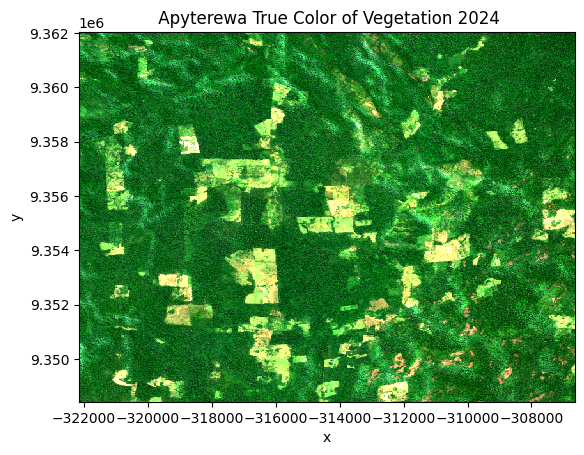

In [6]:
'''
Plotting the True Color of the selected area.
'''

plot_year = 2024 #Choose the year to plot
true_color = data_composite.sel(time=plot_year)[["B4", "B3", "B2"]].to_array()
(true_color * 4).plot.imshow(robust=True)
plt.title(f" Apyterewa True Color of Vegetation {plot_year}")
plt.show()

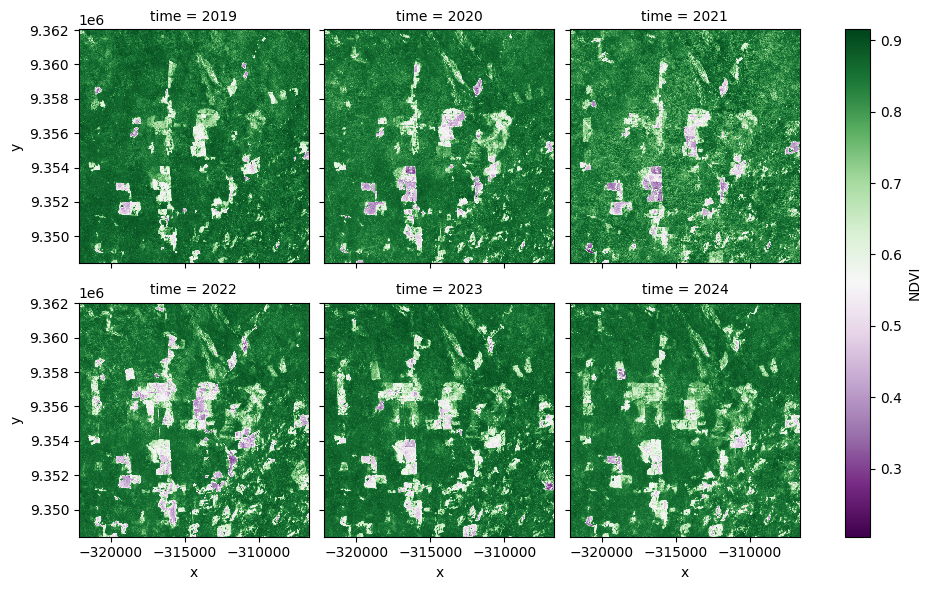

In [7]:
'''
Plotting the time-series of the NDVI in the selected area.
'''

data_composite.NDVI.plot(cmap="PRGn", x="x", y="y", col="time", col_wrap=3)

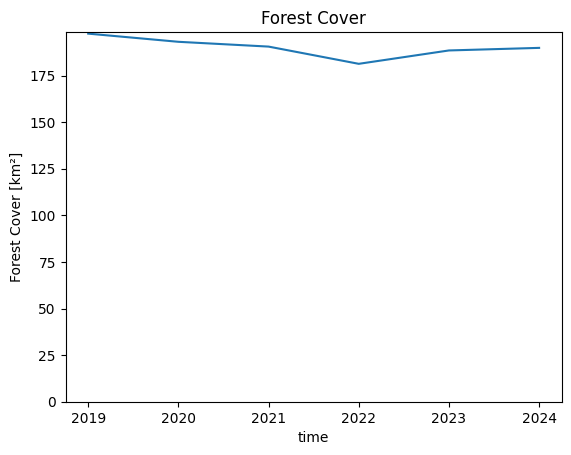

In [8]:
'''
Plotting the Forest Loss trend during the time selected.
'''

# Extracting the resolution of the image in meters
img = rioxarray.open_rasterio("sentinel_exports_composite/2020.tif")
resolution = img.rio.resolution()

# Create a new variable 'FOREST' to classify pixels as forested where NDVI > 0.7
data_composite["FOREST"] = data_composite.NDVI > 0.7

# Calculate the forest area
def to_km2(dataarray, resolution):
    return dataarray * np.prod(list(resolution)) / 1e6

# Plotting
forest_pixels_composite = data_composite.FOREST.sum(["x", "y"])
forest_area_km2_composite = to_km2(forest_pixels_composite, resolution)
forest_area_km2_composite = abs(forest_area_km2_composite)
forest_area_km2_composite.plot()
plt.title("Forest Cover")
plt.ylabel("Forest Cover [km²]")
plt.ylim(0)

Text(0.5, 1.0, 'Forest Change Map 2024')

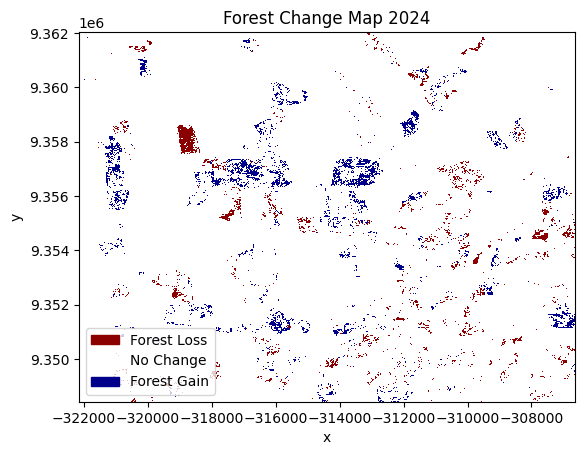

In [9]:
'''
Plotting a map to show forest loss and gain compared to the year before.
'''


# 0 - 0 = No Change: 0
# 1 - 1 = No Change: 0
# 1 - 0 = Forest Gain: 1
# 0 - 1 = Forest Loss: -1

# Define custom colors and labels
colors = ["darkred", "white", "darkblue"]
labels = ["Forest Loss", "No Change", "Forest Gain"]

# Create a colormap and binary variable "CHANGE" that will determine which pixels changed the NDVIs
cmap = mcolors.ListedColormap(colors)
norm = plt.Normalize(-1, 1)
year = 2024
data_composite["CHANGE"] = data_composite.FOREST.astype(int).diff("time", label="upper")
data_composite.CHANGE.sel(time= year).plot(cmap=cmap, norm=norm, add_colorbar=False)

# Create a legend with string labels
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, labels)]
plt.legend(handles=legend_patches, loc="lower left")
plt.title(f"Forest Change Map {year}")

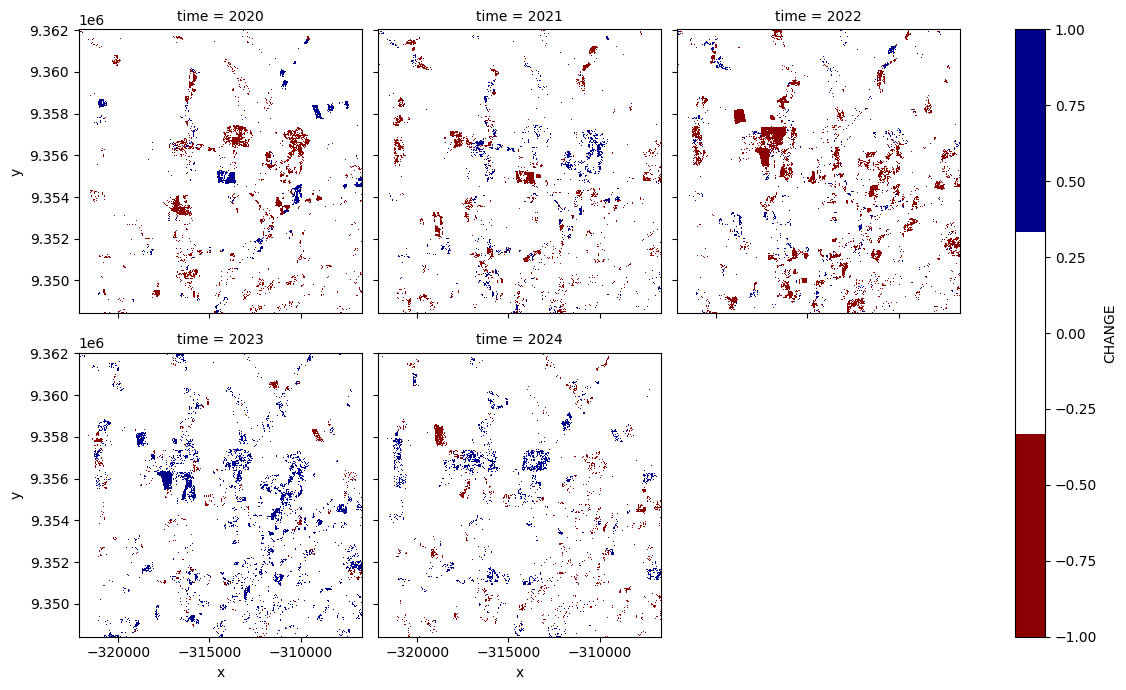

In [11]:
'''
Plottinge the time-series of the Forest Loss and Gain.
'''

data_composite.CHANGE.sel(time=slice(2020, 2024)).plot(
    x="x", y="y",
    col="time", col_wrap=3,
    cmap=cmap,
    norm=norm,
    add_colorbar=True,
    figsize=(12, 7)
)

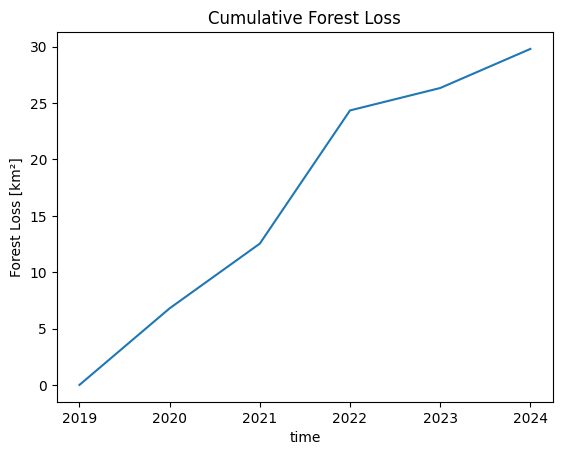

In [10]:
'''
Plotting cumulative forest loss per year.
'''

# Calculate total number of pixels where NDVI has decreased (CHANGE == -1), indicating possible forest loss
forest_loss = (data_composite.CHANGE == -1).sum(["x", "y"])
forest_loss_km2 = to_km2(forest_loss, resolution)
forest_loss_km2 = abs(forest_loss_km2) #because the resolution is (20, -20)
forest_loss_km2.cumsum().plot()
plt.title("Cumulative Forest Loss")
plt.ylabel("Forest Loss [km²]");

Validation of Data

Generating URL ...
Please wait ...
Data downloaded to /content/comparison_hansen.tif


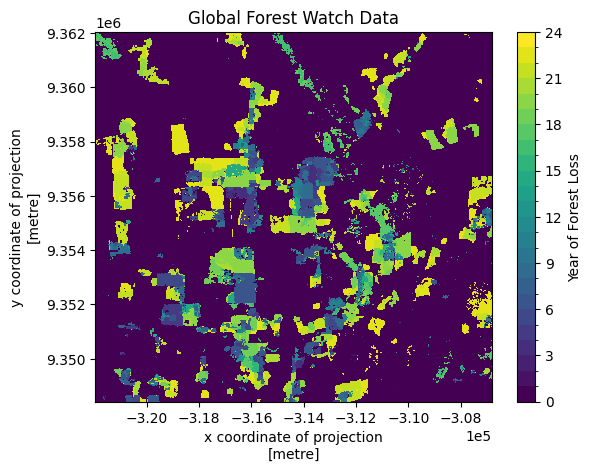

In [17]:
'''
Plotting the Data from Global Forest Watch to use as comparison for validation.
'''


# Importing Hansen from Forest Watch for comparison

comparison_hansen = ee.Image('projects/time-series-analysis-465313/assets/Hansen_lossyear_00N_060W_')
bbox = (-52.404785, -5.845545, -52.267456, -5.725311)

epsg = 31983
bbox = BBox(bbox, CRS(4326)).transform(epsg) # Converting to get the resolution in meters



# Exporting the image as GEOTIFF
geemap.ee_export_image(
        comparison_hansen,
        filename='comparison_hansen.tif',
        scale=20,
        region=area,
        file_per_band=False,
        crs='EPSG: 31983'
    )

comp_data = 'comparison_hansen.tif'


# Creating a Data Array for the image and plotting it
validation_data = (
    xr.open_dataarray(comp_data, engine="rasterio")
    .rio.clip_box(*bbox)
    .sel(band=1)
    .where(lambda gt: gt < 100, 0)
)
validation_data.plot(levels=range(25), cbar_kwargs={"label": "Year of Forest Loss"})
plt.title("Global Forest Watch Data")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0));


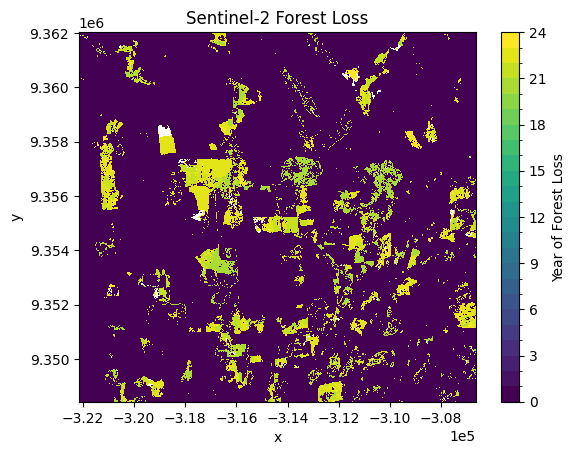

In [18]:
'''
Comparing it with my own Sentinel-2 Data.
'''


#Adding Hansen data to the dataset for comparison
gt_interp_composite = validation_data.interp_like(data_composite, method="nearest")

# Creating variable
data_composite["VALIDATION_DATA"] = gt_interp_composite.fillna(0).astype(int)

# Convert lost forest (-1) into the year it was lost and collapse all into one 2D array by excluding the "time" dimension
lost_year_composite = (data_composite.CHANGE == -1) * data_composite.time % 100
first_nonzero_composite = (lost_year_composite != 0).argmax(axis=0).compute()

# Creating the 2D variable with the array
data_composite["LOST_YEAR"] = lost_year_composite[first_nonzero_composite]
data_composite.LOST_YEAR.plot(levels=range(25), cbar_kwargs={"label": "Year of Forest Loss"}) # I select the 25 for comparison but there's data
plt.title("Sentinel-2 Forest Loss")                                                           # only for 5 years
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0));


In [20]:
'''
Creating accuracy test to compute the proportion of pixels that were correctly assigned as forest loss
by using the data from Global Forest Watch as reference.
'''

score = accuracy_score(
    (data_composite.LOST_YEAR > 19).values.ravel(), (data_composite.VALIDATION_DATA > 19).values.ravel() # Selecting pixels from 20219
)
print(f"The overall accuracy of forest loss detection is {score:.2f}.")

The overall accuracy of forest loss detection is 0.90.
